# Domain adaptation

- Unsupervised Domain Adaptation by Backpropagation, Ganin & Lemptsky (2014)

https://www.youtube.com/watch?v=uUUvieVxCMs&t=1210s

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Function
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.Dropout2d(),
        )        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )
    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)      
        return logits

In [4]:
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """
    
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None

class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [5]:
epochs=100
seed = 1101
batch_size = 64

use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [6]:
model = Net().to(device)
model.load_state_dict(torch.load('conv_for_domain_adaptation.pt'))

In [7]:
feature_extractor = model.feature_extractor
clf = model.classifier

discriminator = nn.Sequential(
    GradientReversal(),
    nn.Linear(320, 50),
    nn.ReLU(),
    nn.Linear(50, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).to(device)

In [8]:
half_batch = batch_size // 2

source_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=half_batch, shuffle=True, **kwargs)

In [11]:
target_loader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=half_batch, shuffle=True, **kwargs)

In [12]:
optim = torch.optim.Adam(list(discriminator.parameters()) + list(model.parameters()))

In [ ]:
for epoch in range(1, epochs+1):
    batches = zip(source_loader, target_loader)
    n_batches = min(len(source_loader), len(target_loader))

    total_domain_loss = total_label_accuracy = 0
    for (source_x, source_labels), (target_x, _) in tqdm(batches, leave=False, total=n_batches):
            x = torch.cat([source_x, target_x])
            x = x.to(device)
            domain_y = torch.cat([torch.ones(source_x.shape[0]),
                                  torch.zeros(target_x.shape[0])])
            domain_y = domain_y.to(device)
            label_y = source_labels.to(device)

            features = feature_extractor(x).view(x.shape[0], -1)
            domain_preds = discriminator(features).squeeze()
            label_preds = clf(features[:source_x.shape[0]])

            domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_y)
            label_loss = F.cross_entropy(label_preds, label_y)
            loss = domain_loss + label_loss

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_domain_loss += domain_loss.item()
            total_label_accuracy += (label_preds.max(1)[1] == label_y).float().mean().item()

    mean_loss = total_domain_loss / n_batches
    mean_accuracy = total_label_accuracy / n_batches
    tqdm.write(f'EPOCH {epoch:03d}: domain_loss={mean_loss:.4f}, '
               f'source_accuracy={mean_accuracy:.4f}')

    torch.save(model.state_dict(), './domain_adaptation/revgrad_' + str(epoch) + '.pt')

  0%|          | 3/1875 [00:00<01:12, 25.95it/s]   

EPOCH 001: domain_loss=0.2626, source_accuracy=0.9026


  0%|          | 3/1875 [00:00<01:20, 23.38it/s]   

EPOCH 002: domain_loss=0.2521, source_accuracy=0.9080


  0%|          | 3/1875 [00:00<01:11, 26.12it/s]   

EPOCH 003: domain_loss=0.2642, source_accuracy=0.9122


  0%|          | 3/1875 [00:00<01:15, 24.79it/s]   

EPOCH 004: domain_loss=0.2516, source_accuracy=0.9150


  0%|          | 2/1875 [00:00<01:38, 19.03it/s]   

EPOCH 005: domain_loss=0.2574, source_accuracy=0.9137


  0%|          | 3/1875 [00:00<01:21, 22.97it/s]   

EPOCH 006: domain_loss=0.2608, source_accuracy=0.9180


  0%|          | 3/1875 [00:00<01:13, 25.32it/s]   

EPOCH 007: domain_loss=0.2649, source_accuracy=0.9183


  0%|          | 3/1875 [00:00<01:10, 26.65it/s]   

EPOCH 008: domain_loss=0.2640, source_accuracy=0.9183


  0%|          | 3/1875 [00:00<01:10, 26.50it/s]   

EPOCH 009: domain_loss=0.2774, source_accuracy=0.9166


  0%|          | 3/1875 [00:00<01:17, 24.23it/s]   

EPOCH 010: domain_loss=0.2727, source_accuracy=0.9192


  0%|          | 2/1875 [00:00<01:37, 19.19it/s]   

EPOCH 011: domain_loss=0.2837, source_accuracy=0.9184


  0%|          | 3/1875 [00:00<01:07, 27.83it/s]          

EPOCH 012: domain_loss=0.2940, source_accuracy=0.9169


  0%|          | 3/1875 [00:00<01:14, 25.29it/s]   

EPOCH 013: domain_loss=0.2969, source_accuracy=0.9167


  0%|          | 3/1875 [00:00<01:04, 28.86it/s]   

EPOCH 014: domain_loss=0.3019, source_accuracy=0.9191


  0%|          | 3/1875 [00:00<01:07, 27.78it/s]   

EPOCH 015: domain_loss=0.3054, source_accuracy=0.9205


  0%|          | 3/1875 [00:00<01:04, 28.89it/s]   

EPOCH 016: domain_loss=0.2994, source_accuracy=0.9200


  0%|          | 3/1875 [00:00<01:05, 28.46it/s]   

EPOCH 017: domain_loss=0.3049, source_accuracy=0.9181


  0%|          | 3/1875 [00:00<01:08, 27.32it/s]   

EPOCH 018: domain_loss=0.3029, source_accuracy=0.9187


  0%|          | 3/1875 [00:00<01:08, 27.50it/s]   

EPOCH 019: domain_loss=0.3030, source_accuracy=0.9204


  0%|          | 3/1875 [00:00<01:07, 27.74it/s]   

EPOCH 020: domain_loss=0.3021, source_accuracy=0.9216


  0%|          | 3/1875 [00:00<01:07, 27.90it/s]   

EPOCH 021: domain_loss=0.3084, source_accuracy=0.9201


  0%|          | 3/1875 [00:00<01:07, 27.85it/s]   

EPOCH 022: domain_loss=0.3019, source_accuracy=0.9207


  0%|          | 3/1875 [00:00<01:08, 27.52it/s]   

EPOCH 023: domain_loss=0.3061, source_accuracy=0.9194


  0%|          | 3/1875 [00:00<01:05, 28.54it/s]   

EPOCH 024: domain_loss=0.3098, source_accuracy=0.9188


  0%|          | 3/1875 [00:00<01:06, 27.98it/s]   

EPOCH 025: domain_loss=0.3035, source_accuracy=0.9221


  0%|          | 3/1875 [00:00<01:07, 27.89it/s]   

EPOCH 026: domain_loss=0.3121, source_accuracy=0.9203


  0%|          | 3/1875 [00:00<01:07, 27.63it/s]   

EPOCH 027: domain_loss=0.3067, source_accuracy=0.9216


  0%|          | 3/1875 [00:00<01:09, 26.84it/s]   

EPOCH 028: domain_loss=0.3063, source_accuracy=0.9224


  0%|          | 3/1875 [00:00<01:07, 27.85it/s]   

EPOCH 029: domain_loss=0.3150, source_accuracy=0.9187


  0%|          | 3/1875 [00:00<01:08, 27.40it/s]   

EPOCH 030: domain_loss=0.3140, source_accuracy=0.9191


  0%|          | 3/1875 [00:00<01:06, 28.23it/s]   

EPOCH 031: domain_loss=0.3154, source_accuracy=0.9200


  0%|          | 3/1875 [00:00<01:07, 27.63it/s]   

EPOCH 032: domain_loss=0.3134, source_accuracy=0.9207


  0%|          | 3/1875 [00:00<01:07, 27.63it/s]   

EPOCH 033: domain_loss=0.3146, source_accuracy=0.9204


  0%|          | 3/1875 [00:00<01:06, 28.21it/s]   

EPOCH 034: domain_loss=0.3156, source_accuracy=0.9201


  0%|          | 3/1875 [00:00<01:05, 28.46it/s]   

EPOCH 035: domain_loss=0.3125, source_accuracy=0.9217


  0%|          | 3/1875 [00:00<01:06, 28.35it/s]   

EPOCH 036: domain_loss=0.3128, source_accuracy=0.9234


  0%|          | 3/1875 [00:00<01:06, 28.24it/s]   

EPOCH 037: domain_loss=0.3129, source_accuracy=0.9203


  0%|          | 3/1875 [00:00<01:07, 27.62it/s]   

EPOCH 038: domain_loss=0.3153, source_accuracy=0.9217


  0%|          | 3/1875 [00:00<01:04, 28.85it/s]   

EPOCH 039: domain_loss=0.3180, source_accuracy=0.9213


  0%|          | 3/1875 [00:00<01:07, 27.86it/s]   

EPOCH 040: domain_loss=0.3179, source_accuracy=0.9222


  0%|          | 3/1875 [00:00<01:07, 27.82it/s]   

EPOCH 041: domain_loss=0.3158, source_accuracy=0.9220


  0%|          | 3/1875 [00:00<01:07, 27.80it/s]   

EPOCH 042: domain_loss=0.3188, source_accuracy=0.9218


  0%|          | 3/1875 [00:00<01:11, 26.30it/s]   

EPOCH 043: domain_loss=0.3190, source_accuracy=0.9222


  0%|          | 3/1875 [00:00<01:10, 26.41it/s]   

EPOCH 044: domain_loss=0.3251, source_accuracy=0.9189


  0%|          | 3/1875 [00:00<01:08, 27.40it/s]   

EPOCH 045: domain_loss=0.3163, source_accuracy=0.9209


  0%|          | 3/1875 [00:00<01:11, 26.18it/s]   

EPOCH 046: domain_loss=0.3168, source_accuracy=0.9237


  0%|          | 3/1875 [00:00<01:05, 28.62it/s]   

EPOCH 047: domain_loss=0.3185, source_accuracy=0.9224


  0%|          | 3/1875 [00:00<01:05, 28.43it/s]   

EPOCH 048: domain_loss=0.3188, source_accuracy=0.9220


  0%|          | 3/1875 [00:00<01:08, 27.51it/s]   

EPOCH 049: domain_loss=0.3149, source_accuracy=0.9205


  0%|          | 3/1875 [00:00<01:07, 27.58it/s]   

EPOCH 050: domain_loss=0.3164, source_accuracy=0.9211


  0%|          | 3/1875 [00:00<01:06, 28.03it/s]   

EPOCH 051: domain_loss=0.3193, source_accuracy=0.9198


  0%|          | 3/1875 [00:00<01:07, 27.73it/s]   

EPOCH 052: domain_loss=0.3172, source_accuracy=0.9237


  0%|          | 3/1875 [00:00<01:06, 27.96it/s]   

EPOCH 053: domain_loss=0.3236, source_accuracy=0.9216


  0%|          | 3/1875 [00:00<01:13, 25.60it/s]   

EPOCH 054: domain_loss=0.3211, source_accuracy=0.9203


  0%|          | 3/1875 [00:00<01:07, 27.83it/s]   

EPOCH 055: domain_loss=0.3228, source_accuracy=0.9213


  0%|          | 3/1875 [00:00<01:08, 27.47it/s]   

EPOCH 056: domain_loss=0.3184, source_accuracy=0.9222


  0%|          | 3/1875 [00:00<01:07, 27.78it/s]   

EPOCH 057: domain_loss=0.3187, source_accuracy=0.9218


  0%|          | 3/1875 [00:00<01:08, 27.53it/s]   

EPOCH 058: domain_loss=0.3183, source_accuracy=0.9216


  0%|          | 3/1875 [00:00<01:08, 27.35it/s]   

EPOCH 059: domain_loss=0.3184, source_accuracy=0.9226


  0%|          | 3/1875 [00:00<01:06, 28.24it/s]   

EPOCH 060: domain_loss=0.3280, source_accuracy=0.9208


EPOCH 061: domain_loss=0.3203, source_accuracy=0.9219


  0%|          | 2/1875 [00:00<01:49, 17.09it/s]   

EPOCH 062: domain_loss=0.3230, source_accuracy=0.9219


  0%|          | 3/1875 [00:00<01:09, 27.11it/s]   

EPOCH 063: domain_loss=0.3254, source_accuracy=0.9210


EPOCH 064: domain_loss=0.3241, source_accuracy=0.9213


  3%|▎         | 55/1875 [23:31<86:21:20, 170.81s/it]

# Visualization of features

In [13]:
nsamples=3000


sample_source_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

sample_target_loader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

In [14]:
imgs_source, labels_source = next(iter(sample_source_loader))
imgs_target, labels_target = next(iter(sample_target_loader))

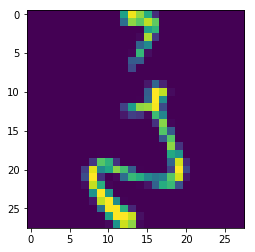

In [15]:
plt.imshow(np.squeeze(imgs_target[0]))

In [16]:
model.load_state_dict(torch.load('conv_for_domain_adaptation.pt'))
model.eval()

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.5)
  )
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [17]:
Feats_source = []
Feats_source.append( model.feature_extractor(imgs_source).view(nsamples,-1) )

Feats_target = []
Feats_target.append( model.feature_extractor(imgs_target).view(nsamples,-1) )

In [18]:
epoch=64
model.load_state_dict(torch.load('./domain_adaptation/revgrad_' + str(epoch) + '.pt') )
model.eval()
    
Feats_source.append( model.feature_extractor(imgs_source).view(nsamples,-1) )
Feats_target.append( model.feature_extractor(imgs_target).view(nsamples,-1) )

In [19]:
from sklearn.manifold import TSNE

In [20]:
TSNE_source = []
TSNE_source.append(TSNE(n_components=2).fit_transform(Feats_source[0].detach().numpy()))

TSNE_target = []
TSNE_target.append(TSNE(n_components=2).fit_transform(Feats_target[0].detach().numpy()))

In [21]:
TSNE_source.append(TSNE(n_components=2).fit_transform(Feats_source[-1].detach().numpy()))
TSNE_target.append(TSNE(n_components=2).fit_transform(Feats_target[-1].detach().numpy()))

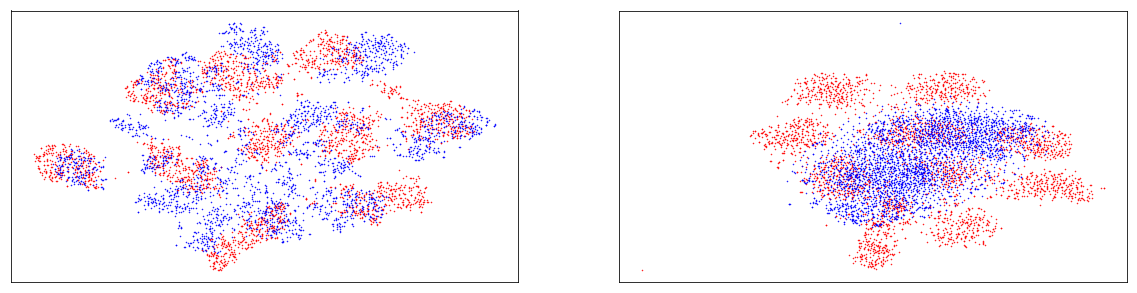

In [23]:
fig=plt.figure(figsize=(20,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    X = TSNE_source[i]
    Y = TSNE_target[i]
    plt.plot(X[:,0], X[:,1], '.r', markersize=1)
    plt.plot(Y[:,0], Y[:,1], '.b', markersize=1)
    plt.xticks([])
    plt.yticks([])
plt.savefig('da_1.png')
plt.show()